In [1]:
from virusPropagationModel import ModeledPopulatedWorld,Simulation
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import os
import timeit
 

In [2]:
start = timeit.default_timer()
modeledWorld1 = ModeledPopulatedWorld(1000,100, world_from_file=False, geofile_name='datafiles/Buildings_Gangelt_MA_1.csv')
stop = timeit.default_timer()
print('required time: ', stop - start)  

required time:  5.096240908


{'home': 223, 'work': 277, 'public_place': 241, 'school': 257}


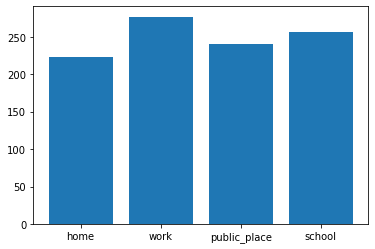

In [ ]:
loc_counts = modeledWorld1.plot_location_type_distribution()
print(loc_counts)

In [4]:
print('Number of agents:'+ str(len(modeledWorld1.people)))

Number of agents:673


In [5]:
start = timeit.default_timer()
simulation1 = Simulation(modeledWorld1,200)
stop = timeit.default_timer()
print('required time: ', stop - start)  

required time:  2.4112121209999993


In [6]:
df  = simulation1.simulation_timecourse

In [14]:
loc_stat=simulation1.get_location_and_status()
print(loc_stat.head())



status  loc  time    D    I    R    S  x_coordinate  y_coordinate
0         4     1  0.0  0.0  0.0  4.0             4             0
1         4     2  0.0  0.0  0.0  4.0             4             0
2         4     3  0.0  0.0  0.0  4.0             4             0
3         4     4  0.0  0.0  0.0  4.0             4             0
4         4     5  0.0  0.0  0.0  4.0             4             0


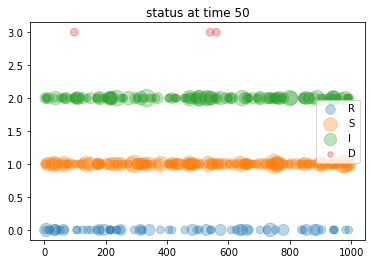

In [17]:
time = 50 
loc_stat_t = loc_stat[loc_stat['time']==time]

for k,stat in enumerate(['R','S','I','D']):
    plt.scatter(loc_stat_t['x_coordinate'],loc_stat_t['y_coordinate']+k, s = 60*loc_stat_t[stat], alpha=0.3, label=stat)
plt.title('status at time '+str(time))
plt.legend()

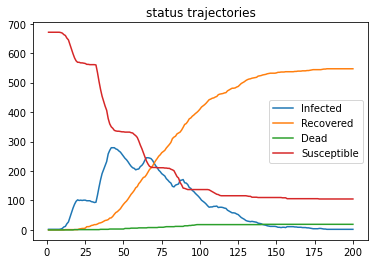

In [9]:
simulation1.plot_status_timecourse()


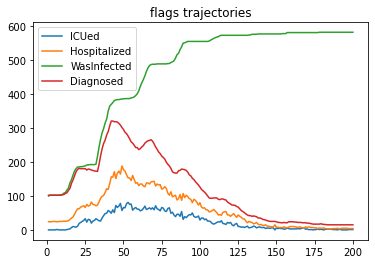

In [10]:
simulation1.plot_flags_timecourse()


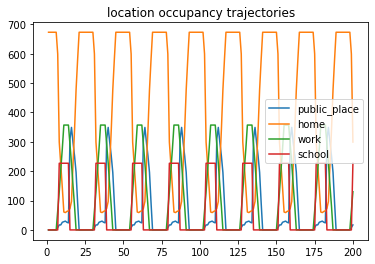

In [11]:
simulation1.plot_location_type_occupancy_timecourse()

In [12]:
simulation1.export_time_courses_as_csvs(identifier='testing') 
# Exports the CSVs to the outputs folder.
# Files marked with the identifier 'testing' get automatically deleted by the testrunner.
# Use a different identifier name if you want your outputs to remain in the folder.
